In [1]:
from pathlib import Path
from mpi4py import MPI


import numpy as np
from petsc4py import PETSc
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from IPython.display import HTML

import seaborn as sns
import pandas as pd
import pyvista as pv


import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem import petsc
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import meshtags
from dolfinx.fem.petsc import (
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc)


In [2]:
H = 5
nx = 2

base = 2
load = 100

T = (60*60*24) * 10 # final time (days)
time_steps = 5
dt = T / time_steps

Cv = 2e-7
Mv = 5e-4


In [3]:

def Boussinesq_2D(X,Z,B, q):
    esp = 1e-12
    Zp = np.maximum(Z,esp)

    term1 = np.arctan((X + B)/Zp) - np.arctan((X - B)/Zp)
    term2 = Zp * ((X + B)/((X + B)**2 + Zp**2) - (X - B)/((X - B)**2 + Zp**2))

    return (q/np.pi) * (term1 + term2) 


In [4]:
msh = mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([-H, -H]), np.array([H, 0])],
    [(nx), (nx)],
    mesh.CellType.triangle,
)

V = fem.functionspace(msh, ("Lagrange", 1))

initial_condition = lambda x: Boussinesq_2D(x[0], -x[1], base, load)


# Solution functions
u_n = fem.Function(V)


# Initial condition
u_n.interpolate(initial_condition)

fdim = msh.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(
    msh, fdim,
    marker=lambda x: np.isclose(x[1], 0.00)
)

dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V)

uh = fem.Function(V)
uh.name = "uh"
uh.interpolate(initial_condition)
# xdmf.write_function(uh,t)


# varational form
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
# PETSc make sure the background stuff doesnt explode
a = (u * v) * ufl.dx + dt * Cv  * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = (u_n) * v * ufl.dx
bilinear_form = fem.form(a)
linear_form = fem.form(L)

A = assemble_matrix(bilinear_form, bcs = [bc])
A.assemble()
b = petsc.create_vector(fem.extract_function_spaces(linear_form))

# creating linear solver 
solver = PETSc.KSP().create(msh.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


u_hist = np.zeros((time_steps, uh.x.array.size), dtype=float)
u_hist[0, :] = uh.x.array.copy()   # initial state
x = V.mesh.geometry.x[:, 0].copy()



In [5]:

for i in range(time_steps - 1):
    with b.localForm() as loc_b:
        loc_b.set(0.0)
    assemble_vector(b, linear_form)

    apply_lifting(b ,[bilinear_form], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,
                mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve
    solver.solve(b, uh.x.petsc_vec)

    # Update time-step solution
    u_n.x.array[:] = uh.x.array
    u_n.x.scatter_forward()

    u_hist[i + 1, :] = uh.x.array.copy()

# xdmf.close()
A.destroy()
b.destroy()
solver.destroy

<bound method KSP.destroy of <petsc4py.PETSc.KSP object at 0xffff345e70b0>>

In [6]:
topology, cell_types, geometry = plot.vtk_mesh(V)
cells = np.asarray(topology).reshape(-1, 4)[:, 1:] 

X = geometry[0,:]
Y = geometry[1,:]

u0 = u_hist[0, :]          # (ndofs,) initial value at each dof
local_dcons = 1 - u_hist / u0[None,:]
local_dcons[:,0] = int(1)

local_dcons.T

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.        , -0.1323697 , -0.0479321 ,  0.02362437,  0.0835897 ],
       [ 0.        ,  0.67483449,  0.4580343 ,  0.25748217,  0.07181726],
       [ 0.        , -0.17074023, -0.13912991, -0.10912706, -0.08062721],
       [ 0.        ,  0.93479088,  0.8147281 ,  0.69892721,  0.5872713 ],
       [ 0.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.        , -5.47659692, -5.47425338, -5.467832  , -5.457836  ],
       [ 0.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [ ]:
settlement = u0 * Mv * (H / nx)

settlement

x_mesh = np.linspace(-H,H,nx)

for i, xn in zip(settlement,X):
    for x in x_mesh:
        if np.isclose(x,xn, atol = 1e-5): 
            print(xn)

print(x_mesh)

-5.000000000000001


In [ ]:
topology, cell_types, geometry = plot.vtk_mesh(V)
cells = np.asarray(topology).reshape(-1, 4)[:, 1:]

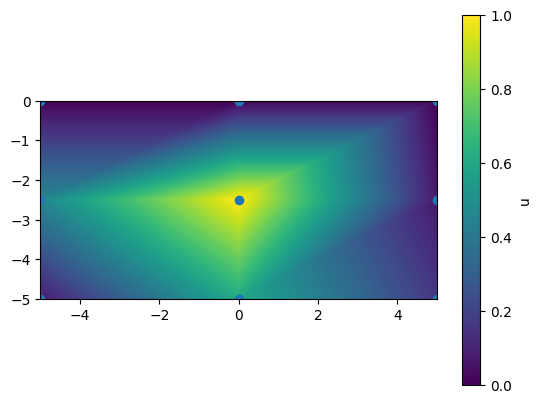

In [ ]:

tri = mtri.Triangulation(geometry[:,0], geometry[:,1], cells)


u_k = u_hist[-1, :geometry.shape[0]]
plt.figure()
plt.tricontourf(tri, u_k, levels=100)
plt.scatter(geometry[:,0], geometry[:,1])
plt.colorbar(label="u")
plt.gca().set_aspect("equal")
plt.show()
